In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import math
import mlflow
from mlflow.tracking import MlflowClient
import optuna
import os

from TMDP import TMDP
from algorithms import *
from model_functions import *
from policy_utils import *
from experiment_result_utils import *
from constants import *


from RiverSwim import *
from CurriculumQ import CurriculumQ

In [2]:
#River Swim Environment
nS = 150
uniform_restart = False
num_runs = 10


small = 5e-3
large = 1.
nA = 2
gamma = 0.999

original_mu = np.zeros(nS)
original_mu[1] = 1
if uniform_restart:
    mu = np.ones(nS) / nS
else:
    mu = original_mu

xi = np.ones(nS) * 1/nS

episodes = 9000000
checkpoint_step=500
test_episodes = 10000
discount_tau = True
param_decay=True
debug = False

lam = 1
experiment_results = []
tests_returns = []
tests_lens = []
exp_taus = []

In [3]:
model_lr = 0.11869281717397965
tau = 0.2
batch_size = 20
exp_rate = 0.4
eps_model = compute_eps_model(gamma, tau, episodes/10)

In [4]:

run_name = f"CurrQ_{uniform_restart}"

mlflow.set_tracking_uri(MLFLOW_URI)
experiment_name = f"RiverSwim_{nS}_{uniform_restart}"
experiment_id = get_or_create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

save_path = f"results/{experiment_name}/run_{run_name}"
label = run_name.split("_")[0]

In [5]:
def run_experiment(index, seed, run_name):
    sub_run_name = f"{run_name}_{index}"
    
    with mlflow.start_run(nested=True, run_name=sub_run_name):
        
        # Environment specific configuration   
        set_policy_seed(seed)
        env = RiverSwim(nS, mu, small=small, large=large, seed=seed)
        
        # Environment independent configuration
        tmdp = TMDP(env, xi, tau=tau, 
                    gamma=gamma, discount_tau=discount_tau, 
                    seed=seed)
        tmdp.update_tau(tau)
        curr_Q = CurriculumQ(tmdp, checkpoint_step=checkpoint_step)

        curr_Q.train(model_lr, batch_size=batch_size, 
                lam=lam, exp_rate=exp_rate,
                episodes=episodes,
                eps_model=eps_model,
                param_decay=param_decay,
                debug=debug,)
    
        avg_return = np.average(curr_Q.reward_records[-10:])/batch_size
        
        mlflow.log_metric("Avg Return", avg_return)
        
        test_policies = test_Q_policies_len(tmdp, curr_Q.Qs, test_episodes, mu=original_mu)
        test_policies_return = test_policies[0]
        test_pol_len = test_policies[1]
        
        result_dict = {
            "Qs" : curr_Q.Qs,
            "taus" : curr_Q.taus,
            "reward_records" : curr_Q.reward_records,
            "test_policies_return" : test_policies_return,
            "index" : index,
            "test_pol_len" : test_pol_len,
        }

        tests_returns.append(test_policies_return)
        experiment_results.append(result_dict)
        tests_lens.append(test_pol_len)
        exp_taus.append(curr_Q.taus)

In [6]:
def run_experiments(num_runs=10):
    with mlflow.start_run(run_name=run_name):
        
        for i in range(num_runs):
            seed = constants.SEEDS[i]
            run_experiment(i, seed, run_name)
        
        pad_results = pad_to_same_length(tests_returns)
        pad_lens = pad_to_same_length(tests_lens)
        pad_taus = pad_to_same_length(exp_taus)
        experiment_dict = {
            "tests_returns": pad_results,
            "taus": pad_taus,
            "tests_lens": pad_lens,
            "num_runs": num_runs,
            "label": label,
            "checkpoint_step": checkpoint_step,
            "uniform_restart": uniform_restart,
        }
        

        mlflow.set_tags(tags={
            "seed": seed,
            "tau": tau,
            "gamma": gamma,
            "checkpoint_step": checkpoint_step,
            "test_episodes": test_episodes,
            "episodes": episodes,
            "model_lr": model_lr,
            "batch_size": batch_size,
            "lam": lam,
            "eps_model": eps_model,
            "exp_rate": exp_rate,
            "param_decay": param_decay,
            "discount_tau": discount_tau,
            "small": small,
            "large": large,
            "uniform_restart": uniform_restart,
        })

        try:
            save_to_mlflow(experiment_dict)
        except Exception as e:
            print(e)
            print("Something went wrong saving the experiment results to MLFlow.")
            print("Saving locally instead.")
            time.sleep(5)
            save(save_path, experiment_dict)

        rewards_fig = plot_avg_test_return(tests_returns, f"{run_name[:-3]} Avg Return on {num_runs} runs")
        try:
            mlflow.log_figure(figure=rewards_fig, artifact_file="reward_image.png")
        except Exception as e:
            print(e)
            print("Something went wrong saving the figure to MLFlow.")
            print("Saving locally instead.")
            time.sleep(5)
            rewards_fig.savefig(save_path+"/reward_image.png")

Current seed for result reproducibility: 2999
Episode: 5000 reward: 0.07200655999271112 tau 0.19989333345185173
Episode: 10000 reward: 0.07601794442450618 tau 0.1998097779891356
Episode: 15000 reward: 0.08003099996555556 tau 0.19967400036222188
Episode: 20000 reward: 0.0720370199588667 tau 0.19957133380962916
Episode: 25000 reward: 1.6611172709808102 tau 0.19944466728370308
Episode: 30000 reward: 0.08006477770580252 tau 0.19934400072888817
Episode: 35000 reward: 1.6695739415845083 tau 0.19923666751481392
Episode: 40000 reward: 0.07608273435251738 tau 0.1991206676437027
Episode: 45000 reward: 0.07208843990173343 tau 0.19900244555283836
Episode: 50000 reward: 0.8691934986738902 tau 0.19889044567728265
Episode: 55000 reward: 0.8773295718560316 tau 0.19878244579728252
Episode: 60000 reward: 0.07612514652761497 tau 0.19867089036567745
Episode: 65000 reward: 0.8615341427398415 tau 0.19855800160222054
Episode: 70000 reward: 0.8696675225916414 tau 0.19845622393752904
Episode: 75000 reward: 0.0

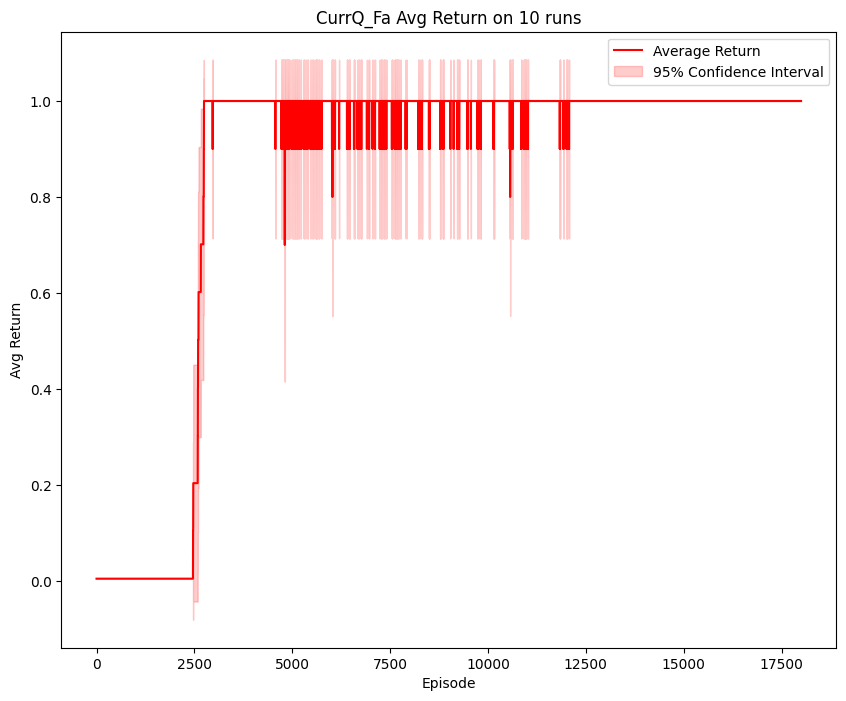

In [7]:
run_experiments(num_runs=num_runs)